<a href="https://colab.research.google.com/github/fadibechara/MultiGrid/blob/main/MultiGrid_Isotropic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from math import pi, sin, cos, sqrt
import pylab as plt
import numpy as np
import scipy as sp
import scipy.sparse as spa
import scipy.linalg as la
import math
import time
#from matplotlib import rc, rcParams
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)
#rcParams.update({'font.size': 16})

# Some paramters
_eps =1e-12
_maxiter=500

def _basic_check(A, b, x0):
    """ Common check for clarity """
    n, m = A.shape
    if(n != m):
        raise ValueError("Only square matrix allowed")
    if(b.size != n):
        raise ValueError("Bad rhs size")
    if (x0 is None):
        x0 = np.zeros(n)
    if(x0.size != n):
        raise ValueError("Bad initial value size")
    return x0

In [4]:
def plot_heatmap(u):
  N=u.size
  n=int(math.sqrt(N))
  u = np.reshape(u, (n,n))
  plt.imshow(u, cmap='hot', interpolation='nearest')
  plt.show()

In [5]:
def JOR(A, b, x, omega, eps, maxiter):

    #x = _basic_check(A, b, x0)
    r = np.zeros(x.shape)    
    residual_history = list()
    disp_history = list()
    n = x.size
    count = 0
    disp = eps+1
    while (count<maxiter and disp>eps):
        xn = np.zeros(n)
        for i in range(n):  
            s = b[i]
            for t in [y for y in range(0,n) if y!=i]:
                s = s - (A[i][t])*x[t]
            xn[i]=(1-omega)*x[i]+(omega/A[i][i])*s
        r = (xn[0]-x[0])*(xn[0]-x[0])    
        disp = (xn[0]-x[0])*(xn[0]-x[0])
        for i in range(1,n):
            r = r + (xn[i]-x[i])*(xn[i]-x[i])  
            dispc=(xn[i]-x[i])*(xn[i]-x[i])
            if(dispc>disp):
               disp=dispc
        x = xn[:]
        r = math.sqrt(r)
        disp = math.sqrt(disp)
        residual_history.append(r)
        disp_history.append(disp)
        count = count+1

    return x, residual_history, disp_history, count


In [6]:
def SOR(A, b, x, omega=1.5, eps=_eps, maxiter=_maxiter):
    start_time = time.time()
    if (omega > 2.) or (omega < 0.):
        raise ArithmeticError("SOR will diverge")

    #x = _basic_check(A, b, x0)   
    residual_history = list()
    disp_history = list()
    n = b.size
    count = 0
    disp = eps+1
    while (count<maxiter and disp>eps):
        xn = np.zeros(n)
        for i in range(n):  
            s = b[i]
            for t in range(i):
                s = s - A[i][t]*xn[t]
            for t in range(i+1, n):
                s = s - A[i][t]*x[t]
            xn[i]=(1-omega)*x[i]+(omega/(A[i][i]))*s
        r = (xn[0]-x[0])*(xn[0]-x[0])    
        disp = (xn[0]-x[0])*(xn[0]-x[0])
        for i in range(1,n):
            r = r + (xn[i]-x[i])*(xn[i]-x[i])  
            dispc=(xn[i]-x[i])*(xn[i]-x[i])
            if(dispc>disp):
               disp=dispc
        x = xn[:]
        r = math.sqrt(r)
        residual_history.append(r)
        disp_history.append(disp)
        count = count+1
    elapsed_time = time.time() - start_time
    print(elapsed_time)
    return x, residual_history, disp_history, count

In [7]:
#Sparse sor function for a more efficient matrix vector multiplication with less unbenificial computations, this function can only be used in this particular case though
def sparse_SOR(A, b, x, omega=1.5, eps=_eps, maxiter=_maxiter):
    start_time = time.time()
    if (omega > 2.) or (omega < 0.):
        raise ArithmeticError("SOR will diverge")

    #x = _basic_check(A, b, x0)   
    residual_history = list()
    disp_history = list()
    N = b.size
    n = int(math.sqrt(N))
    count = 0
    disp = eps+1
    while (count<maxiter and disp>eps):
          xn = np.zeros(N)
          for i in range(n,N-n):
            if i%n == 0 or (i+1)%n == 0:
             continue
            s = b[i]
           #if(i<n or i>(n*(n-1)-1)):
           #for t in range(i):
                #s = s - A[i][t]*xn[t]
           #for t in range(i+1, N):
                #s = s - A[i][t]*x[t]           
           #else:
            s = s - A[i][i-n]*xn[i-n] - A[i][i-1]*xn[i-1] - A[i][i+1]*x[i+1] - A[i][i+n]*x[i+n]
            xn[i]=(1-omega)*x[i]+(omega/(A[i][i]))*s
          r = (xn[0]-x[0])*(xn[0]-x[0])    
          disp = (xn[0]-x[0])*(xn[0]-x[0])
          for i in range(n,N-n):
            if i%n == 0 or (i+1)%n == 0:
             continue
            r = r + (xn[i]-x[i])*(xn[i]-x[i])  
            dispc=(xn[i]-x[i])*(xn[i]-x[i])
            if(dispc>disp):
               disp=dispc
          x = xn[:]
          r = math.sqrt(r)
          disp = math.sqrt(disp)
          residual_history.append(r)
          disp_history.append(disp)
          count = count+1
    elapsed_time = time.time() - start_time
    print(elapsed_time)
    return x, residual_history, disp_history, count

In [8]:
def v_multigrid(x, min=2, omega=1.633):
  start_time = time.time()
  a=x.size
  rank=0
  while(a!=1):
    a=int(a/2)
    rank=rank+1
  count=rank
  print(rank)
  print('         Start restriction')
  i=1
  while(count>(min)):
    N=x.size
    print(N)
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h)
    f = function(N,h)
    e=(1/i)
    x,r,d,c = sparse_SOR(A,f,x,omega,e,10000)
    print(c)
    plot_heatmap(x)
    x=restrict_injection(x)
    i=i*1000000000
    count=count-2
  print(x)
  print(count)
  print('GOAL COUNT')
  print(rank)
  print(x.size)
  print('         Start prolognation')
  while(count<(rank+1)):
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h)
    f = function(N,h)
    e=(1/i)
    x,r,d,c = sparse_SOR(A,f,x,omega,e,10000)
    x,r,d,c1 = sparse_SOR(A,f,x,omega,1e-7,10000)
    print(x.size)
    print(c)
    #print(c1)
    plot_heatmap(x)
    if(count!=rank):
      x=prolongate(x)
    print(x.size)
    i=i/100000000
    count=count+2

  
  elapsed_time = time.time() - start_time
  print('V_MultiGrid Took')
  print(elapsed_time)
  return x

In [9]:
def w_multigrid(x, min=4, intermediate=6,  omega=1.633, sig=1):
  start_time = time.time()
  a=x.size
  rank=0
  while(a!=1):
    a=int(a/2)
    rank=rank+1
  count=rank
  print(rank)
  print('                   Start restriction')
  i=1
  while(count>(min)):
    N=x.size
    print(N)
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h, sig)
    f = function(N,h)
    e=(1/i)
    x,r,d,c = sparse_SOR(A,f,x,omega,e,i)
    print(c)
    plot_heatmap(x)
    x=restrict_injection(x)
    i=i*1000
    count=count-2
  print(x)
  print(count)
  print('GOAL COUNT')
  print(rank)
  print(x.size)
  print('                     Start prolognation to intermediate phase')

  while(count<(intermediate+1)):
    e=(1/i)
    i=i/1000
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h, sig)
    f = function(N,h)
    x,r,d,c = sparse_SOR(A,f,x,omega,e,10000)
    print(x.size)
    print(c)
    plot_heatmap(x)
    if(count!=rank):
      x=prolongate_injection(x)
    print(x.size)
    i=i/10000
    count=count+2


  print('                   Start restriction from intermediate phase to minimum COARSE phase')
  while(count>(min)):
    i=i*1000
    N=x.size
    print(N)
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h, sig)
    f = function(N,h)
    e=(1/i)/1000000000
    x,r,d,c = sparse_SOR(A,f,x,omega,e,10000)
    print(c)
    plot_heatmap(x)
    x=restrict_injection(x)
    count=count-2

  print('                   Start prolongation from minimum COARSE phase to FINE grid')
  
  while(count<(rank+1)):
    c=0
    c1=0
    e=(1/i)
    i=i/1000
    N=x.size
    n=int(math.sqrt(N))
    h=1/(n)
    A = fivediag(N, n ,h, sig)
    f = function(N,h)
    if (count!=rank):
      x,r,d,c = sparse_SOR(A,f,x,omega,1e-15,1000)
    else:
      x,r,d,c = sparse_SOR(A,f,x,omega,1e-6,10000)
    print(x.size)
    print(c)
    plot_heatmap(x)
    if (count!=rank):
      x=prolongate_injection(x)
    print(x.size)
    count=count+2

  
  elapsed_time = time.time() - start_time
  print('W_MultiGrid Took')
  print(elapsed_time)
  return x

In [10]:
def fivediag(N, n, h, sigma=0):
  a=[4+h*h*sigma]*N
  b=[-1]*(N-1)
  c=[-1]*(N-1)
  d=[-1]*(N-n)
  e=[-1]*(N-n)
  A = np.diag(a, 0) + np.diag(b, -1) + np.diag(c, 1) + np.diag(d, -n) + np.diag(e, n)
  A = np.reshape(A, (N, N))
  return A

In [11]:
def function(N,h):
  f = np.empty(N, dtype=float)
  n=int(math.sqrt(N))
  for i in range(0,n):
    for j in range(0,n):
      f[i*n+j]=(h**2)*(i*n+j)*(i*n+j)*(h**2)
  return f


In [12]:
def restrict_full(u):
  s=np.size(u,0)
  s=int(math.sqrt(s))
  n=int(s/2)
  uc = np.empty(n*n, dtype=float)
  uc[0]=(4*u[0]+2*u[s]+2*u[1]+u[s+1])/9
  for i in range(1, n):
    uc[i]=(4*u[2*i]+2*u[2*i-1]+2*u[2*i+1]+2*u[2*i+s]+u[2*i+s-1]+u[2*i+s+1])/12

  for i in range(1,n):
    uc[n*i]=(4*u[2*i*s]+2*u[(2*i-1)*s]+2*u[(2*i+1)*s]+2*u[2*i*s+1]+u[(2*i+1)*s+1]+u[(2*i-1)*s-1])/12
    for j in range(1,n):
      uc[n*i+j]=(4*u[2*i*s+2*j] + 2*u[2*i*s+2*j-1] + 2*u[2*i*s+2*j+1] + 2*u[(2*i-1)*s+2*j] + 2*u[(2*i+1)*s+2*j] + u[(2*i+1)*s+2*j+1] + u[(2*i+1)*s+2*j-1] + u[(2*i-1)*s+2*j+1] + u[(2*i-1)*s+2*j-1])/16

  return uc




In [13]:
def restrict_half(u):
  s=np.size(u,0)
  s=int(math.sqrt(s))
  n=int(s/2)
  uc = np.empty(n*n, dtype=float)
  uc[0]=(4*u[0]+u[s]+u[1])/6
  for i in range(1, n):
    uc[i]=(4*u[2*i]+u[2*i-1]+u[2*i+1]+u[2*i+s])/7

  for i in range(1,n):
    uc[n*i]=(4*u[2*i*s]+u[(2*i-1)*s]+u[(2*i+1)*s]+u[2*i*s+1])/7
    for j in range(1,n):
      uc[n*i+j]=(4*u[2*i*s+2*j] + u[2*i*s+2*j-1] + u[2*i*s+2*j+1] + u[(2*i-1)*s+2*j] + u[(2*i+1)*s+2*j])/8

  return uc

In [14]:
def restrict_injection(u):
  s=np.size(u,0)
  s=int(math.sqrt(s))
  n=int(s/2)
  uc = np.empty(n*n, dtype=float)
  uc[0] = u[0]
  for i in range(1, n):
    uc[i]=u[2*i]

  for i in range(1,n):
    uc[n*i]= u[2*i*s]
    for j in range(1,n):
      uc[n*i+j]= u[2*i*s+2*j]

  return uc

In [15]:
def prolongate(u):
  s=np.size(u)
  s=int(math.sqrt(s))
  n=int(2*s)
  uf = np.zeros((n)*(n), dtype=float)
  for i in range(0,n,2):
    for j in range(0,n,2):
      uf[i*n+j]=u[int((i/2)*s+j/2)]
    for j in range(1,n-1,2):
      uf[i*n+j]=(uf[i*n+j-1]+uf[i*n+j+1])/2
    uf[i*n+n-1]=uf[i*n+n-2]

  for i in range(1,n-2,2):
    for j in range(0,n):
      uf[i*n+j]=(uf[(i-1)*n+j]+uf[(i+1)*n+j])/2
  for j in range(0,n):
    uf[(n-1)*n+j]=uf[(n-2)*n+j]

  return uf


In [16]:
def prolongate_injection(u):
  s=np.size(u)
  n=int(math.sqrt(s))
  N=int(2*n)
  uf = np.zeros((N)*(N), dtype=float)
  for i in range(0,s):
    j = int(i/n)
    p = i - j*n
    uf[j*2*N+p*2]=uf[j*2*N+p*2+1]=uf[j*2*N+p*2+N]=uf[j*2*N+p*2+N+1]=u[i]
   

  return uf


In [17]:
e=14
#This is our initial guess 
u = np.arange(start=1, stop=2**e+1, step=1, dtype=float)
#u = np.zeros(2**e)  
u.size

16384

14
                   Start restriction
16384
0.09297537803649902
1


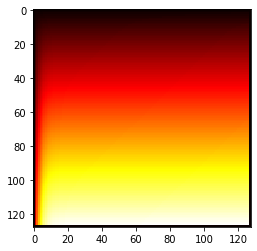

4096
20.932708024978638
1000


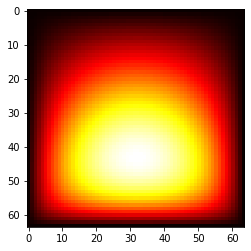

1024
1.5823678970336914
320


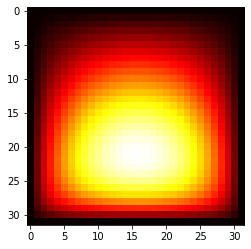

256
0.08982443809509277
86


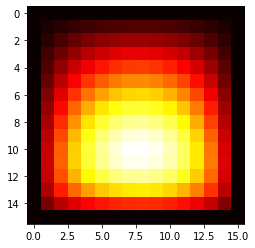

64
0.013306617736816406
67


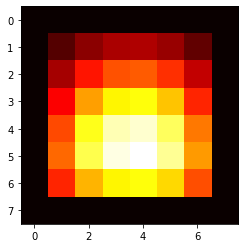

[0.         0.         0.         0.         0.         0.43780715
 0.55541165 0.30186355 0.         0.84869639 1.04819365 0.59865424
 0.         0.69776958 0.83264805 0.53209612]
4
GOAL COUNT
14
16
                     Start prolognation to intermediate phase
0.0032999515533447266
16
77


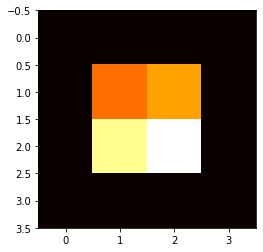

64
                   Start restriction from intermediate phase to minimum COARSE phase
64
1.9812028408050537
10000


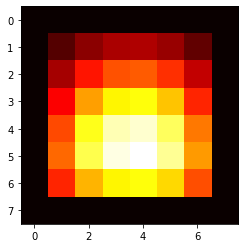

                   Start prolongation from minimum COARSE phase to FINE grid
0.0032024383544921875
16
77


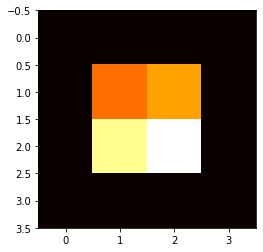

64
0.015234947204589844
64
78


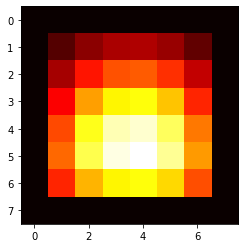

256
1.0773868560791016
256
1000


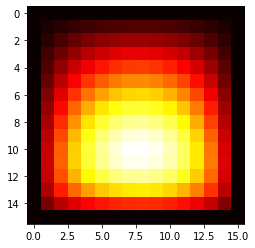

1024
4.873617649078369
1024
1000


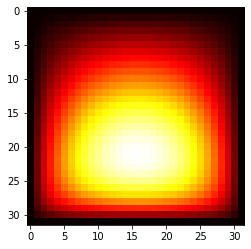

4096
20.95611882209778
4096
1000


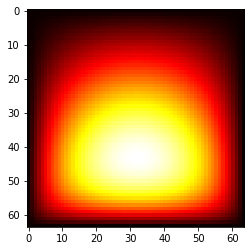

16384
439.7760970592499
16384
4996


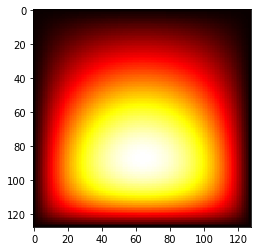

16384
W_MultiGrid Took
503.21262884140015


In [18]:
x = w_multigrid(u, 4, 4, 1.633, 0)

Conventional SOR exclusively on the FINE grid took
541.7551958560944


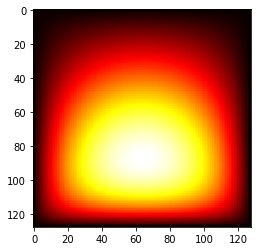

In [19]:
N=u.size    
n=int(math.sqrt(N))
h=1/(n)
A = fivediag(N, n ,h, 0)
f = function(N,h)
print('Conventional SOR exclusively on the FINE grid took')
u2,r,d,c = sparse_SOR(A,f,u,1.633,1e-6,400000)
plot_heatmap(u2)